In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import pipeline, AutoTokenizer

from nltk.tokenize import sent_tokenize
import nltk

In [69]:
df = pd.read_csv('../data/usage_yelp.csv')

In [72]:
import torch
import pandas as pd
from transformers import pipeline
from nltk.tokenize import sent_tokenize
import nltk

# Download required NLTK data
nltk.download('punkt')

# Check if CUDA (GPU) is available and set the device
device = 0 if torch.cuda.is_available() else -1

# Load the sentiment analysis pipeline with truncation enabled
sentiment_analyzer = pipeline(
    "sentiment-analysis", 
    model="distilbert-base-uncased-finetuned-sst-2-english", 
    device=device,
    truncation=True,
    max_length=512
)

# Define candidate aspect labels
candidate_labels = [
    "Food Quality",
    "Service",
    "Ambiance",
    "Wait Time",
    "Price/Value",
    "Menu Variety",
    "Cleanliness"
]

def analyze_sentiment(text):
    """
    Performs sentiment analysis on the given text and returns a 1-5 rating.
    """
    try:
        result = sentiment_analyzer(text)[0]
        sentiment_score = result["score"]

        # Convert to 1-5 scale
        if result["label"] == "POSITIVE":
            return min(5, max(3, 3 + (sentiment_score - 0.5) * 4))
        else:
            return min(3, max(1, 3 - (sentiment_score - 0.5) * 4))
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

# Process sentiment analysis for each review and aspect
for idx, row in df.iterrows():
    try:
        review_sentences = sent_tokenize(row["review_text"])
        
        # Analyze each aspect
        for aspect in candidate_labels:
            if row[aspect] >= 0.4:  # High confidence that this aspect is present
                # Get sentiment for each sentence
                sentence_sentiments = []
                for sent in review_sentences:
                    sentiment = analyze_sentiment(sent)
                    if sentiment is not None:
                        sentence_sentiments.append(sentiment)
                
                # Calculate average sentiment if we have valid sentiments
                if sentence_sentiments:
                    avg_sentiment = sum(sentence_sentiments) / len(sentence_sentiments)
                    df.at[idx, f"{aspect}_Sentiment"] = round(avg_sentiment)
                else:
                    df.at[idx, f"{aspect}_Sentiment"] = None
            else:
                df.at[idx, f"{aspect}_Sentiment"] = None
    except Exception as e:
        print(f"Error processing row {idx}: {e}")
        continue

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zachg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Device set to use cuda:0


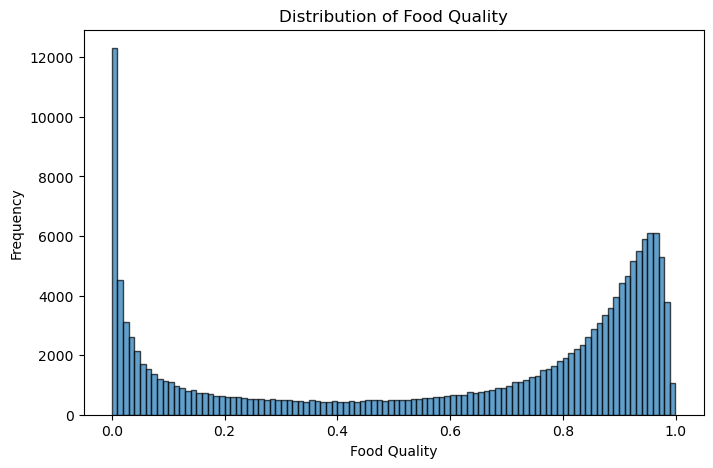

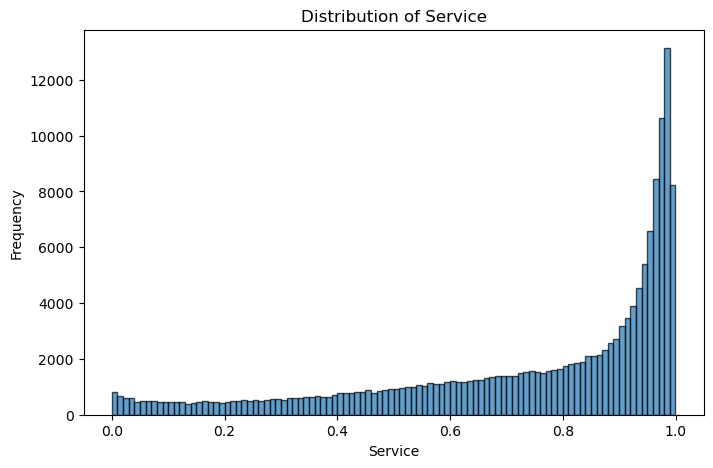

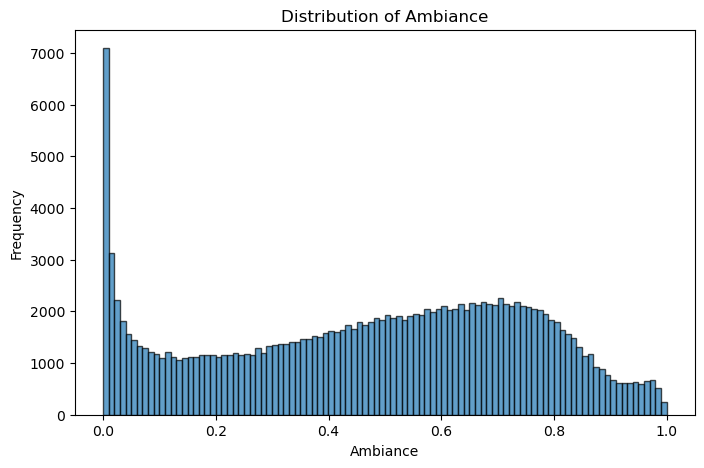

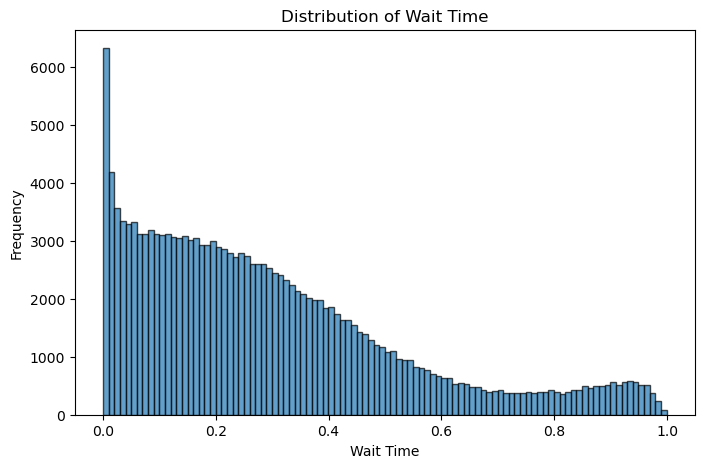

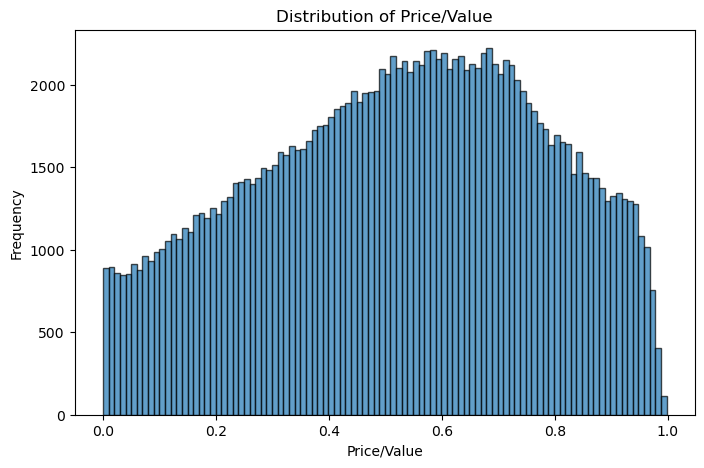

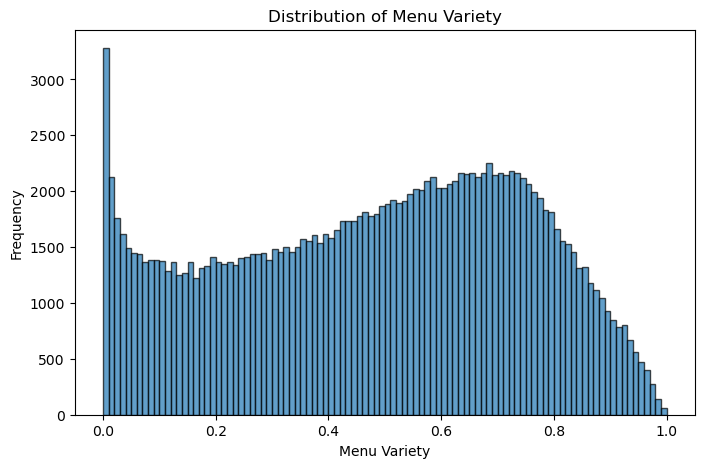

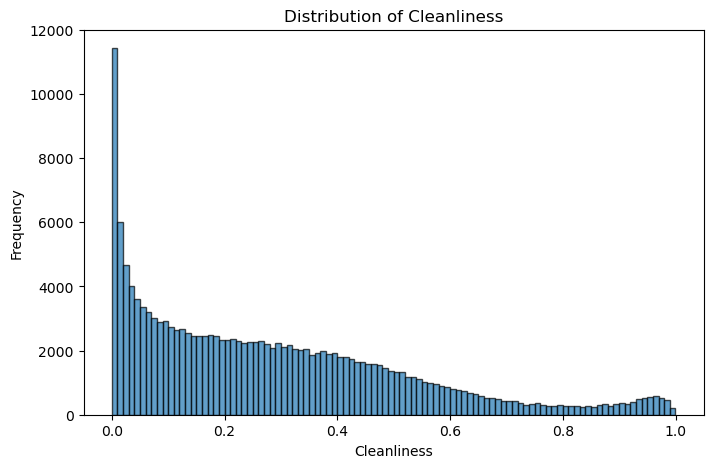

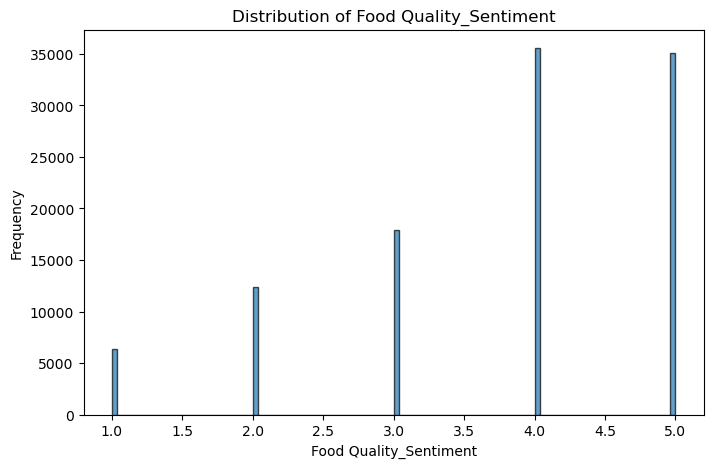

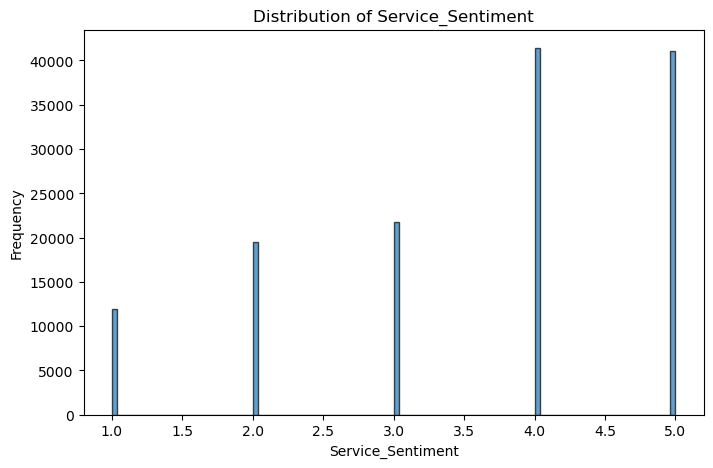

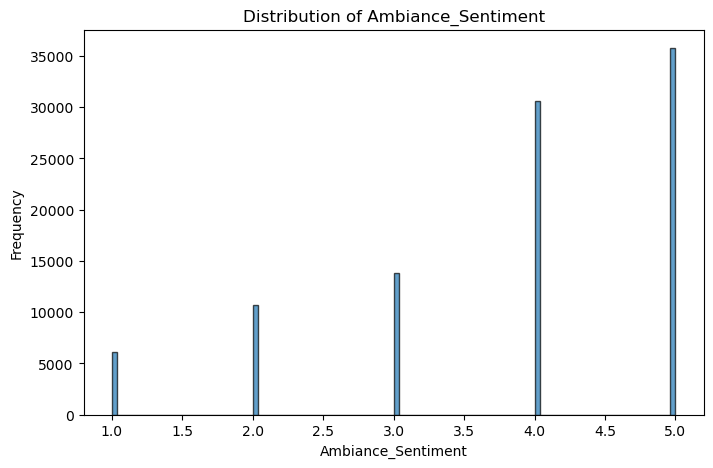

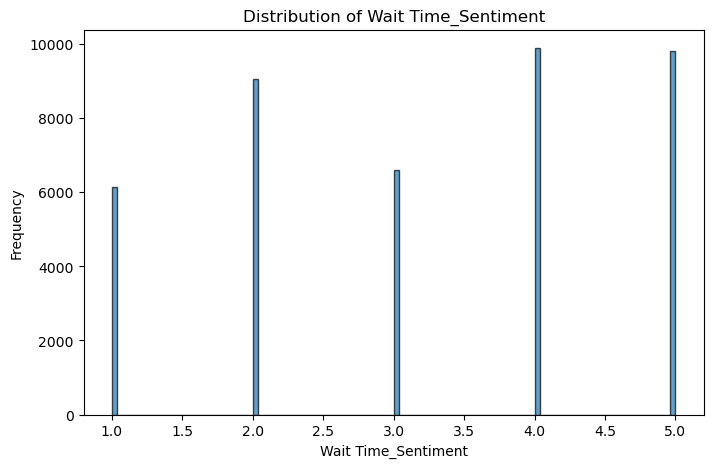

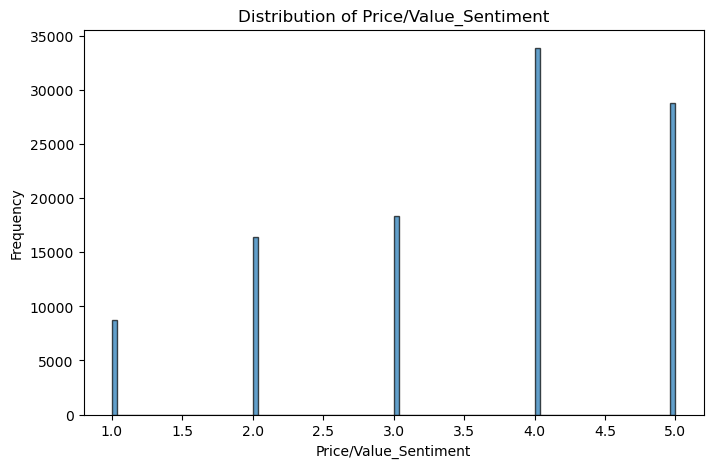

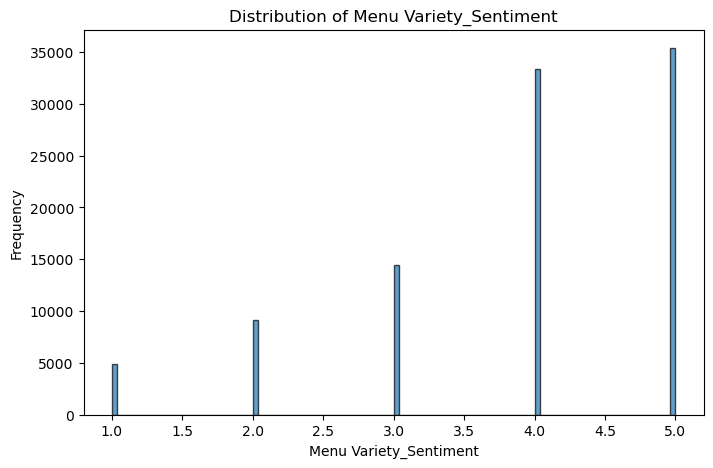

In [74]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Plot histograms for each numeric column
for col in numeric_cols.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col].dropna(), bins=100, edgecolor='black', alpha=0.7)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.show()

In [86]:
len(df)

156937

In [116]:
frequent_businesses = df['business_name'].value_counts()
frequent_businesses = frequent_businesses[frequent_businesses > 110]

# Get the list of business names that appear more than 5 times
frequent_business_names = frequent_businesses.index.tolist()

# Filter the original dataframe to only include these businesses
filtered_df = df[df['business_name'].isin(frequent_business_names)]

# Display the first few rows and the shape of the filtered dataframe
print(f"Shape of filtered dataframe: {filtered_df.shape}")
filtered_df.head()

Shape of filtered dataframe: (55945, 21)


,review_text,Food Quality,Service,Ambiance,Wait Time,Price/Value,Menu Variety,Cleanliness,business_id,user_id,...,review_date,business_city,attributes,Food Quality_Sentiment,Service_Sentiment,Ambiance_Sentiment,Wait Time_Sentiment,Price/Value_Sentiment,Menu Variety_Sentiment,Cleanliness_Sentiment
0,The oysters here were amazing. The raw oysters...,0.904089,0.961304,0.734387,0.456808,0.745752,0.713770,0.309262,_ab50qdWOk0DdB6XOrBitw,f9IKEjKCNZ_l8AqA5H0Xmg,...,2020-01-18,New Orleans,"{""RestaurantsTakeOut"":""True"",""Alcohol"":""'full_...",4.0,4.0,4.0,4.0,4.0,4.0,None
1,Char broiled oysters are the bomb! My boyfrien...,0.633277,0.241952,0.298222,0.029431,0.022147,0.223638,0.001584,_ab50qdWOk0DdB6XOrBitw,bq7lX3c3fsFjUmVzVhgELw,...,2020-01-04,New Orleans,"{""RestaurantsTakeOut"":""True"",""Alcohol"":""'full_...",3.0,NaN,NaN,NaN,NaN,NaN,None
2,"The charbroiled oysters were delicious, cheese...",0.815513,0.433760,0.402189,0.029045,0.253536,0.521807,0.022661,_ab50qdWOk0DdB6XOrBitw,Id_VrcgaxwbG6t_upjGZ3Q,...,2020-01-24,New Orleans,"{""RestaurantsTakeOut"":""True"",""Alcohol"":""'full_...",4.0,4.0,4.0,NaN,NaN,4.0,None
3,We came a few minutes after it opened so we di...,0.919579,0.452685,0.604372,0.398239,0.939389,0.760565,0.186585,_ab50qdWOk0DdB6XOrBitw,pPr5MRSj8QiB2F2vg_QsAA,...,2020-01-05,New Orleans,"{""RestaurantsTakeOut"":""True"",""Alcohol"":""'full_...",5.0,5.0,5.0,NaN,5.0,5.0,None
4,Im not a fan of seafood lets just say that. Bu...,0.968794,0.987599,0.303442,0.350131,0.825735,0.650473,0.138133,_ab50qdWOk0DdB6XOrBitw,z0qnaHebiScP798mdfLNEA,...,2020-01-25,New Orleans,"{""RestaurantsTakeOut"":""True"",""Alcohol"":""'full_...",3.0,3.0,NaN,NaN,3.0,3.0,None


In [121]:
filtered_df = filtered_df[filtered_df['business_city'] != 'NASHVILLE']

In [125]:
filtered_df.to_csv('../data/aspect_sentiments.csv', index=False)

In [126]:
filtered_df['business_city'].value_counts()

business_city
New Orleans    31149
Nashville      24796
Name: count, dtype: int64

In [127]:
filtered_df.columns

Index(['review_text', 'Food Quality', 'Service', 'Ambiance', 'Wait Time',
       'Price/Value', 'Menu Variety', 'Cleanliness', 'business_id', 'user_id',
       'business_name', 'review_date', 'business_city', 'attributes',
       'Food Quality_Sentiment', 'Service_Sentiment', 'Ambiance_Sentiment',
       'Wait Time_Sentiment', 'Price/Value_Sentiment',
       'Menu Variety_Sentiment', 'Cleanliness_Sentiment'],
      dtype='object')